# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense
import numpy as np
from tensorflow import keras
import keras.backend as K
from scipy.ndimage.interpolation import zoom
from PIL import Image, ImageDraw
tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [4]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(32, (3,3), strides=1, 
       input_shape=(28, 28, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
cnn_model.add(Conv2D(64, (3,3), strides=1, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(10))

In [5]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [6]:
# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(Flatten(input_shape=(28, 28, 1)))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))

In [7]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


# Teacher loss function

In [8]:
@tf.function
def compute_teacher_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))


  return cross_entropy_loss_value

# Student loss function

In [10]:
# Hyperparameters for distillation (need to be tuned).
#ALPHA = 0.5 # task balance between cross-entropy and distillation loss
#DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))

  # Compute the total loss 
  total_loss = ALPHA*cross_entropy_loss_value+(1-ALPHA)*distillation_loss_value

  return total_loss

# Train and evaluation

In [11]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, ALPHA, DISTILLATION_TEMPERATURE):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

In [ ]:
# your code start from here for step 5 
# Teacher Model
train_and_evaluate(cnn_model, compute_teacher_loss, 0.5, 4)

Epoch 1: Class_accuracy: 97.95%
Epoch 2: Class_accuracy: 98.66%
Epoch 3: Class_accuracy: 98.86%
Epoch 4: Class_accuracy: 99.00%
Epoch 5: Class_accuracy: 99.16%
Epoch 6: Class_accuracy: 99.22%
Epoch 7: Class_accuracy: 99.06%
Epoch 8: Class_accuracy: 99.23%
Epoch 9: Class_accuracy: 99.27%
Epoch 10: Class_accuracy: 99.35%
Epoch 11: Class_accuracy: 99.31%
Epoch 12: Class_accuracy: 99.27%


In [ ]:
cnn_model.save("Teacher_Model.h5")
cnn_model.save_weights("Teacher_Weights")

In [ ]:
# Student Model: ALPHA=0.5, DISTILLATION_TEMPERATURE=4
train_and_evaluate(fc_model, compute_student_loss, 0.5, 4)

Epoch 1: Class_accuracy: 96.68%
Epoch 2: Class_accuracy: 98.13%
Epoch 3: Class_accuracy: 98.41%
Epoch 4: Class_accuracy: 98.56%
Epoch 5: Class_accuracy: 98.62%
Epoch 6: Class_accuracy: 98.75%
Epoch 7: Class_accuracy: 98.71%
Epoch 8: Class_accuracy: 98.80%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.76%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.77%


In [ ]:
fc_model.save("Student_Model_0.5_4.h5")
fc_model.save_weights("Student_Weights_0.5_4")

## Tune Alpha


In [ ]:
# Student Model: ALPHA=0.25, DISTILLATION_TEMPERATURE=4
train_and_evaluate(fc_model, compute_student_loss, 0.25, 4)

Epoch 1: Class_accuracy: 98.80%
Epoch 2: Class_accuracy: 98.81%
Epoch 3: Class_accuracy: 98.81%
Epoch 4: Class_accuracy: 98.87%
Epoch 5: Class_accuracy: 98.89%
Epoch 6: Class_accuracy: 98.93%
Epoch 7: Class_accuracy: 98.80%
Epoch 8: Class_accuracy: 98.93%
Epoch 9: Class_accuracy: 98.92%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.88%
Epoch 12: Class_accuracy: 98.93%


In [ ]:
fc_model.save("Student_Model_0.25_4.h5")
fc_model.save_weights("Student_Weights_0.25_4")

## Tune Temperature

In [ ]:
# Student Model: ALPHA=0.25, DISTILLATION_TEMPERATURE=2
train_and_evaluate(fc_model, compute_student_loss, 0.25, 2)

Epoch 1: Class_accuracy: 97.38%
Epoch 2: Class_accuracy: 97.93%
Epoch 3: Class_accuracy: 98.31%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.47%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.54%
Epoch 9: Class_accuracy: 98.59%
Epoch 10: Class_accuracy: 98.66%
Epoch 11: Class_accuracy: 98.66%
Epoch 12: Class_accuracy: 98.69%


In [ ]:
fc_model.save("Student_Model_0.25_2.h5")
fc_model.save_weights("Student_Weights_0.25_2")

In [ ]:
# Student Model: ALPHA=0.25, DISTILLATION_TEMPERATURE=6
train_and_evaluate(fc_model, compute_student_loss, 0.25, 6)

Epoch 1: Class_accuracy: 98.60%
Epoch 2: Class_accuracy: 98.57%
Epoch 3: Class_accuracy: 98.59%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.59%
Epoch 7: Class_accuracy: 98.59%
Epoch 8: Class_accuracy: 98.66%
Epoch 9: Class_accuracy: 98.67%
Epoch 10: Class_accuracy: 98.72%
Epoch 11: Class_accuracy: 98.66%
Epoch 12: Class_accuracy: 98.66%


In [ ]:
fc_model.save("Student_Model_0.25_6.h5")
fc_model.save_weights("Student_Weights_0.25_6")

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6 
T = [1,2,4,16,32,64]
for t in T:
  print("Temperature is {}".format(t))
  train_and_evaluate(fc_model, compute_student_loss, ALPHA=0.5, DISTILLATION_TEMPERATURE=t)

Temperature is 1
Epoch 1: Class_accuracy: 98.59%
Epoch 2: Class_accuracy: 98.51%
Epoch 3: Class_accuracy: 98.56%
Epoch 4: Class_accuracy: 98.41%
Epoch 5: Class_accuracy: 98.52%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.61%
Epoch 8: Class_accuracy: 98.61%
Epoch 9: Class_accuracy: 98.54%
Epoch 10: Class_accuracy: 98.50%
Epoch 11: Class_accuracy: 98.22%
Epoch 12: Class_accuracy: 98.45%
Temperature is 2
Epoch 1: Class_accuracy: 98.49%
Epoch 2: Class_accuracy: 98.51%
Epoch 3: Class_accuracy: 98.49%
Epoch 4: Class_accuracy: 98.51%
Epoch 5: Class_accuracy: 98.56%
Epoch 6: Class_accuracy: 98.55%
Epoch 7: Class_accuracy: 98.56%
Epoch 8: Class_accuracy: 98.58%
Epoch 9: Class_accuracy: 98.62%
Epoch 10: Class_accuracy: 98.57%
Epoch 11: Class_accuracy: 98.44%
Epoch 12: Class_accuracy: 98.51%
Temperature is 4
Epoch 1: Class_accuracy: 98.37%
Epoch 2: Class_accuracy: 98.45%
Epoch 3: Class_accuracy: 98.31%
Epoch 4: Class_accuracy: 98.58%
Epoch 5: Class_accuracy: 98.53%
Epoch 6: Class_

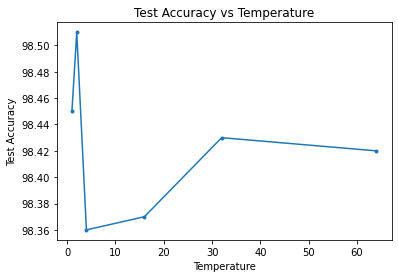

In [ ]:
plt.figure()
T = [1,2,4,16,32,64]
accuracy_list = [98.45,98.51,98.36,98.37,98.43,98.42]
plt.plot(T, accuracy_list,'.-')
#plt.axis([1, 64, 98, 99])
plt.title("Test Accuracy vs Temperature")
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy')
plt.show()

# Train student from scratch

In [11]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation.add(Flatten(input_shape=(28, 28, 1)))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(10))

fc_model_no_distillation.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 784)               615440    
                                                                 
 dense_6 (Dense)             (None, 784)               615440    
                                                                 
 dense_7 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def compute_plain_cross_entropy_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits/DISTILLATION_TEMPERATURE))*DISTILLATION_TEMPERATURE**2

  
  return cross_entropy_loss

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss, 0.5, 4)

Epoch 1: Class_accuracy: 95.96%
Epoch 2: Class_accuracy: 96.97%
Epoch 3: Class_accuracy: 97.74%
Epoch 4: Class_accuracy: 97.68%
Epoch 5: Class_accuracy: 98.09%
Epoch 6: Class_accuracy: 97.97%
Epoch 7: Class_accuracy: 98.24%
Epoch 8: Class_accuracy: 98.00%
Epoch 9: Class_accuracy: 98.19%
Epoch 10: Class_accuracy: 98.05%
Epoch 11: Class_accuracy: 98.03%
Epoch 12: Class_accuracy: 97.99%


In [ ]:
fc_model_no_distillation.save("Student_Model_wokd_0.5_4.h5")
fc_model_no_distillation.save_weights("Student_Weights_wokd_0.5_4")

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [12]:
# your code start from here for step 8
!pip install keras-flops
from keras_flops import get_flops

     |████████████████████████████████| 462 kB 7.1 MB/s 


In [13]:
# Load Models
# Load the previously trained teacher model
teacher_model=tf.keras.models.load_model('/content/drive/MyDrive/ECE1512/dict/Teacher_Model.h5')
teacher_model.load_weights('/content/drive/MyDrive/ECE1512/dict/Teacher_Weights')

# Load the previously trained student model with KD
student_w_kd_model=tf.keras.models.load_model('/content/drive/MyDrive/ECE1512/dict/Student_Model_0.5_4.h5')
student_w_kd_model.load_weights('/content/drive/MyDrive/ECE1512/dict/Student_Weights_0.5_4')

# Load the previously trained student model without KD
student_wo_kd_model=tf.keras.models.load_model('/content/drive/MyDrive/ECE1512/dict/Student_Model_wokd_0.5_4.h5')
student_wo_kd_model.load_weights('/content/drive/MyDrive/ECE1512/dict/Student_Weights_wokd_0.5_4')

In [14]:
# Teacher Model FLOPs
flops = get_flops(teacher_model, batch_size=1)
print("Teacher Model")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# Student Model(w/ KD) FLOPs
flops = get_flops(student_w_kd_model, batch_size=1)
print("Student Model With KD")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# Student Model(w/o KD) FLOPs
flops = get_flops(student_wo_kd_model, batch_size=1)
print("Student Model Without KD")
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Teacher Model
FLOPS: 0.022 G
Student Model With KD
FLOPS: 0.00248 G
Student Model Without KD
FLOPS: 0.00248 G


# XAI method to explain models

In [15]:
#Code in Project A:
def create_random_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)
    return mask

def RISE(img, model, class_index, N_MASKS=8000, H=28, W=28, C=1):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()
        #print(x.shape)
        #print(m.shape)
        x[:, :, 0] *= m
        #x[:, :, 1] *= m
        #x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

## Get a Sample Image

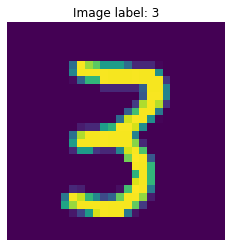

In [59]:
# Get one batch
mnist_sample_batch, = mnist_test.take(1)
images_batch, labels_batch = mnist_sample_batch

# Plot image samples
import random
random.seed(50)
number = random.randint(0,255)
sample_image = tf.squeeze(images_batch[number])
sample_label = np.argmax(labels_batch[number])
# plt.figure(figsize=(12,12))
plt.imshow(sample_image)
plt.axis("off")
plt.title("Image label: {}".format(sample_label))
plt.show()

## Predictions of Three Models

In [60]:
#Predictions from Teacher Model， Student Model w/ KD, and Student Model w/o KD
tracher_pred = np.argmax(tf.nn.softmax(teacher_model(tf.expand_dims(sample_image, axis=0))))
student_w_kd_pred = np.argmax(tf.nn.softmax(student_w_kd_model(tf.expand_dims(sample_image, axis=0))))
student_wo_kd_pred = np.argmax(tf.nn.softmax(student_wo_kd_model(tf.expand_dims(sample_image, axis=0))))
print("Teacher Predict Result:",tracher_pred,"\nStudent With KD Predict Result:",student_w_kd_pred,"\nStudent Without KD Predict Result",student_wo_kd_pred)

Teacher Predict Result: 3 
Student With KD Predict Result: 3 
Student Without KD Predict Result 3


## RISE Methods Explain the three models

In [66]:
# Get Explanation Maps from three models
Teacher_RISE = RISE(images_batch[number].numpy(), teacher_model, class_index=sample_label, N_MASKS=8000)
Teacher_RISE -= Teacher_RISE.min()
Teacher_RISE /= Teacher_RISE.max()+10e-30

Student_w_kd_RISE = RISE(images_batch[number].numpy(), student_w_kd_model, class_index=sample_label, N_MASKS=8000)
Student_w_kd_RISE -= Student_w_kd_RISE.min()
Student_w_kd_RISE /= Student_w_kd_RISE.max()+10e-30

Student_wo_kd_RISE = RISE(images_batch[number].numpy(), student_wo_kd_model, class_index=sample_label, N_MASKS=8000)
Student_wo_kd_RISE -= Student_wo_kd_RISE.min()
Student_wo_kd_RISE /= Student_wo_kd_RISE.max()+10e-30

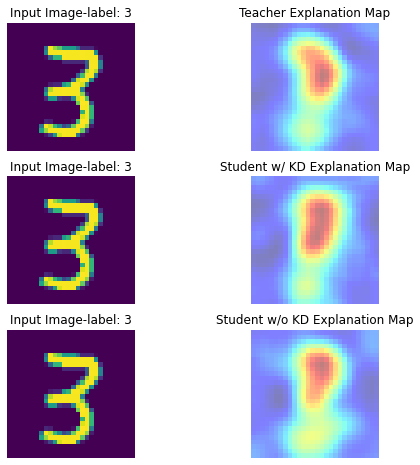

In [67]:
# Plot Three explanation map from different models
# Teacher Model
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis("off")

plt.subplot(3,2,2)
plt.title('Teacher Explanation Map')
plt.imshow(Teacher_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

# Student w/ KD Model
plt.subplot(3,2,3)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,4)
plt.title('Student w/ KD Explanation Map')
plt.imshow(Student_w_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

# Student w/o KD Model
plt.subplot(3,2,5)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,6)
plt.title('Student w/o KD Explanation Map')
plt.imshow(Student_wo_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()

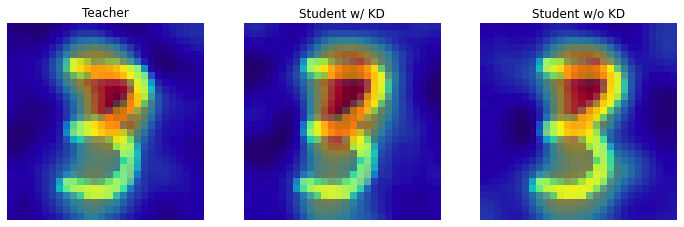

In [68]:
#Merge input and explanation maps
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.title('Teacher')
plt.imshow(sample_image)
plt.imshow(Teacher_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Student w/ KD')
plt.imshow(sample_image)
plt.imshow(Student_w_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Student w/o KD')
plt.imshow(sample_image)
plt.imshow(Student_wo_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13



##TAKD

### Model creation

In [35]:
#teacher
teacher_takd = tf.keras.Sequential()
teacher_takd.add(Conv2D(32, (3,3), strides=1, 
       input_shape=(28, 28, 1), activation='relu'))
teacher_takd.add(MaxPooling2D(pool_size=(2,2), strides=1))
teacher_takd.add(Conv2D(64, (3,3), strides=1, activation='relu'))
teacher_takd.add(MaxPooling2D(pool_size=(2,2), strides=2))
teacher_takd.add(Flatten())
teacher_takd.add(Dropout(rate=0.5))
teacher_takd.add(Dense(128, activation='relu'))
teacher_takd.add(Dropout(rate=0.5))
teacher_takd.add(Dense(10))

teacher_takd.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                                                                 
 dropout_2 (Dropout)         (None, 7744)             

In [36]:
#teacher assistant
TA = tf.keras.Sequential()
TA.add(Conv2D(32, (3,3), strides=1,
       input_shape=(28, 28, 1), activation='relu'))
TA.add(MaxPooling2D(pool_size=(2,2), strides=2))
TA.add(Flatten())
TA.add(Dense(784, activation='relu'))
TA.add(Dense(784, activation='relu'))
TA.add(Dense(10))

TA.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_7 (Dense)             (None, 784)               4240656   
                                                                 
 dense_8 (Dense)             (None, 784)               615440    
                                                                 
 dense_9 (Dense)             (None, 10)                7850      
                                                      

In [37]:
#student
student_takd = tf.keras.Sequential()
student_takd.add(Flatten(input_shape=(28, 28, 1)))
student_takd.add(Dense(784, activation='relu'))
student_takd.add(Dense(784, activation='relu'))
student_takd.add(Dense(10))

student_takd.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 784)               615440    
                                                                 
 dense_11 (Dense)            (None, 784)               615440    
                                                                 
 dense_12 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


### Teacher loss function

In [38]:
@tf.function
def compute_teacher_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_takd(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))


  return cross_entropy_loss_value

### Distillation loss

In [39]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

### TA loss function

In [40]:
def compute_TA_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = TA(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.
  teacher_subclass_logits = teacher_takd(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))

  # Compute the total loss 
  total_loss = ALPHA*cross_entropy_loss_value+(1-ALPHA)*distillation_loss_value

  return total_loss

### Student loss function

In [41]:
def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_takd(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.
  teacher_subclass_logits = TA(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))

  # Compute the total loss 
  total_loss = ALPHA*cross_entropy_loss_value+(1-ALPHA)*distillation_loss_value

  return total_loss

### # Train and evaluation

In [46]:
# Teacher Model
train_and_evaluate(teacher_takd, compute_teacher_loss, 0.5, 4)

Epoch 1: Class_accuracy: 99.46%
Epoch 2: Class_accuracy: 99.42%
Epoch 3: Class_accuracy: 99.40%
Epoch 4: Class_accuracy: 99.33%
Epoch 5: Class_accuracy: 99.34%
Epoch 6: Class_accuracy: 99.45%
Epoch 7: Class_accuracy: 99.39%
Epoch 8: Class_accuracy: 99.32%
Epoch 9: Class_accuracy: 99.35%
Epoch 10: Class_accuracy: 99.29%
Epoch 11: Class_accuracy: 99.39%
Epoch 12: Class_accuracy: 99.49%


In [47]:
teacher_takd.save("Teacher_TAKD.h5")
teacher_takd.save_weights("Teacher_Weights_TAKD")

In [48]:
# TA KD
train_and_evaluate(TA, compute_TA_loss, 0.5, 4)

Epoch 1: Class_accuracy: 97.80%
Epoch 2: Class_accuracy: 98.67%
Epoch 3: Class_accuracy: 98.94%
Epoch 4: Class_accuracy: 99.00%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 99.07%
Epoch 7: Class_accuracy: 99.03%
Epoch 8: Class_accuracy: 99.07%
Epoch 9: Class_accuracy: 99.16%
Epoch 10: Class_accuracy: 99.03%
Epoch 11: Class_accuracy: 99.13%
Epoch 12: Class_accuracy: 99.15%


In [49]:
TA.save("TA_TAKD.h5")
TA.save_weights("TA_Weights_TAKD")

In [50]:
# Student KD
train_and_evaluate(student_takd, compute_student_loss, 0.5, 4)

Epoch 1: Class_accuracy: 96.00%
Epoch 2: Class_accuracy: 97.34%
Epoch 3: Class_accuracy: 97.84%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.39%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.43%
Epoch 8: Class_accuracy: 98.54%
Epoch 9: Class_accuracy: 98.62%
Epoch 10: Class_accuracy: 98.63%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.81%


In [51]:
student_takd.save("student_TAKD.h5")
student_takd.save_weights("student_Weights_TAKD")

## Comparing the teacher, teacher assistant, and student model (number of of parameters and FLOPs)

In [54]:
flops = get_flops(teacher_takd, batch_size=1)
print("teacher_takd Model")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
flops = get_flops(TA, batch_size=1)
print("TA_takd Model")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
flops = get_flops(student_takd, batch_size=1)
print("student_takd Model")
print(f"FLOPS: {flops / 10 ** 9:.03} G")

teacher_takd Model
FLOPS: 0.022 G
TA_takd Model
FLOPS: 0.0102 G
student_takd Model
FLOPS: 0.00248 G


### RISE explanation maps of all models

In [61]:
# Get Explanation Maps from three models
Teacher_TAKD_RISE = RISE(images_batch[number].numpy(), teacher_takd, class_index=sample_label, N_MASKS=8000)
Teacher_TAKD_RISE -= Teacher_TAKD_RISE.min()
Teacher_TAKD_RISE /= Teacher_TAKD_RISE.max()+10e-30

TA_TAKD_RISE = RISE(images_batch[number].numpy(), TA, class_index=sample_label, N_MASKS=8000)
TA_TAKD_RISE -= TA_TAKD_RISE.min()
TA_TAKD_RISE /= TA_TAKD_RISE.max()+10e-30

Student_TAKD_RISE = RISE(images_batch[number].numpy(), student_takd, class_index=sample_label, N_MASKS=8000)
Student_TAKD_RISE -= Student_TAKD_RISE.min()
Student_TAKD_RISE /= Student_TAKD_RISE.max()+10e-30

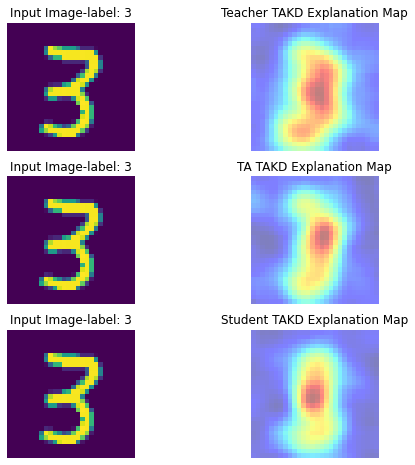

In [62]:
# Teacher TAKD Model
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis("off")

plt.subplot(3,2,2)
plt.title('Teacher TAKD Explanation Map')
plt.imshow(Teacher_TAKD_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

# Student w/ KD Model
plt.subplot(3,2,3)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,4)
plt.title('TA TAKD Explanation Map')
plt.imshow(TA_TAKD_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

# Student w/o KD Model
plt.subplot(3,2,5)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,6)
plt.title('Student TAKD Explanation Map')
plt.imshow(Student_TAKD_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()

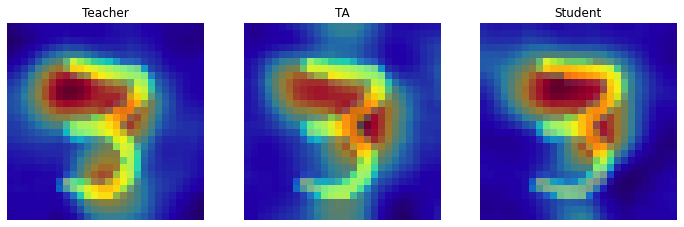

In [63]:
#Merge input and explanation maps
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.title('Teacher')
plt.imshow(sample_image)
plt.imshow(Teacher_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('TA')
plt.imshow(sample_image)
plt.imshow(Student_w_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Student')
plt.imshow(sample_image)
plt.imshow(Student_wo_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()